### Linear model
**with and without regularization**
for  1) flattened input and 2) convoluted input


In [20]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import tensorflow as tf
from sklearn.linear_model import RidgeCV
import random
import seaborn as sns

In [3]:
# preprocess: data import, shuffle, switch axes, flattening , convolution. detailed in notebk 'rgb_data_load_mod.ipynb'.

b = np.load('../Downloads/depth_training_data.npz')
data_rgb = b['rgb_images']                # RGB DATA 
data_depth = b['depth_maps']              # DEPTH DATA 
data_rgb = data_rgb/255
data_depth = data_depth - data_depth.min()
# switch axes for plotting
data_rgb = data_rgb.transpose(0,2,3,1)
data_depth = data_depth.transpose(0,2,3,1)
# shuffle images
random.seed(400)
random.shuffle(data_depth)     # inplace method
random.seed(400)
random.shuffle(data_rgb)
# flatten
X = data_rgb.reshape(data_rgb.shape[0],27648)        
Y = data_depth.reshape(data_depth.shape[0],9216)
#conv
input_shape = data_rgb.shape
x = data_rgb  # no padding, strides default
y = tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=input_shape[1:])(x)
x_f = tf.keras.layers.MaxPool2D()(y)
x_f.shape
y1 = tf.keras.layers.Conv2D(96, 3, activation='relu')(x_f)
y1.shape
x_ff = tf.keras.layers.MaxPool2D()(y1)
x_ff.shape
y11 = tf.keras.layers.Conv2D(96, 3, activation='relu')(x_ff)
y11.shape
x_fff = tf.keras.layers.MaxPool2D()(y11)
x_fff.shape

x_fff = tf.keras.layers.GlobalAveragePooling2D()(x_fff) 

xconv = x_fff.numpy()

2022-01-01 17:26:37.603226: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### simple LINEAR MODEL , repeated k-fold with k = 7 

In [4]:
model = LinearRegression() 
# X is flattened rgb data (3500,27468) & Y is flattened depth data (3500,9216)

s = cross_val_score(model, X, Y , cv=7, n_jobs=-1, scoring="neg_mean_squared_error") 

m = np.abs(np.mean(s))
print("model mse is %3.5f"% m ) 

model mse is 0.03673


In [5]:
print("validation scores on flattened rgb fit \n",np.abs(s))

validation scores on flattened rgb fit 
 [0.00518148 0.012771   0.03222208 0.05737864 0.04024556 0.04770275
 0.06160749]


#### LINEAR model with Convoluted X data, cv = 7

In [6]:
s_xconv = cross_val_score(model, xconv, Y , cv=7, n_jobs=-1, scoring="neg_mean_squared_error") 

m1 = np.abs(np.mean(s_xconv))
print("model with Convoluted x has mse %3.5f"% m1 ) 

model with Convoluted x has mse 0.00790


#### Linear model with Ridge penalty 

In [31]:
l_ridge = RidgeCV(alphas=[0.01, 0.1, 0.5, 1, 2, 5, 10], cv=7, scoring='neg_mean_squared_error') 
l_ridge.fit(X,Y)
print('best alpha is',l_ridge.alpha_,'with mse' ,-l_ridge.best_score_)

best alpha is 10.0 with mse 0.01290457295056242


In [30]:
conv_ridge = RidgeCV(alphas=[0.01, 0.1, 0.5, 1, 2, 5, 10], cv=7, scoring='neg_mean_squared_error') 
conv_ridge.fit(xconv,Y)
print('best alpha is',conv_ridge.alpha_,'with mse' ,-conv_ridge.best_score_)

best alpha is 0.01 with mse 0.010016511593546187


#### Predicting with best model - simple linear model with Convolved x and no penalty

In [9]:
#Splitting data into train and test dataset
x_train, x_test, y_train, y_test = train_test_split(xconv,Y, test_size= 0.20, random_state = 98)

print("<storing color img data for comparison later>")
colorimg_train, colorimg_test = train_test_split(data_rgb, test_size= 0.20, random_state = 98)


<storing color img data for comparison later>


In [32]:
m = model.fit(x_train, y_train)
ypred = m.predict(x_test)
print(mean_squared_error(ypred, y_test))

0.008548492


#### Plotting with best model

Text(0.5, 1.0, 'predicted depth image')

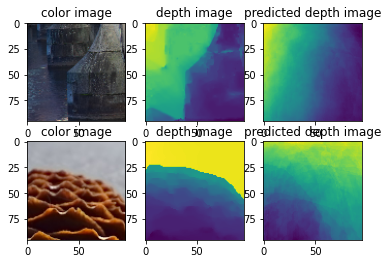

In [13]:
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(colorimg_test[210])
axarr[0,1].imshow(y_test[210].reshape(96,96,1))
axarr[0,2].imshow(ypred[210].reshape(96,96,1))
axarr[0,0].set_title('color image')
axarr[0,1].set_title('depth image')
axarr[0,2].set_title('predicted depth image')
axarr[1,0].imshow(colorimg_test[410])
axarr[1,1].imshow(y_test[410].reshape(96,96,1))
axarr[1,2].imshow(ypred[410].reshape(96,96,1))
axarr[1,0].set_title('color image')
axarr[1,1].set_title('depth image')
axarr[1,2].set_title('predicted depth image')

while model does not capture details very well, it does a good job on learning parts of img as being near/far.
best mse for linear models is 0.008 for simple lin reg model with convoluted rgb data (cv = 7) 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

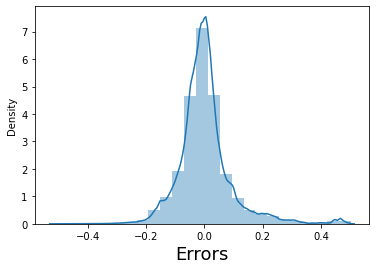

In [54]:
# residuals 
res = ypred - y_test
fig = plt.figure()
sns.distplot(res, bins = 25)                
plt.xlabel('Errors', fontsize = 18)   

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
residuals shape (700, 9216)
model coef shape (9216, 96)

 Residuals summary 
 count    9216.000000
mean        0.086255
std         0.010717
min         0.055768
25%         0.080024
50%         0.086313
75%         0.092062
max         0.118854
dtype: float64

 coefs summary
 count       96.000000
mean       533.451355
std       5209.419922
min      -1071.137207
25%        -10.459731
50%          1.134817
75%          8.865098
max      51025.015625
dtype: float64


Text(0, 0.5, 'predicted depth')

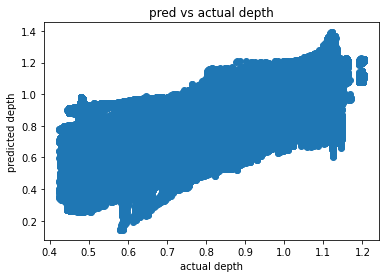

In [72]:
# plot res vs coefs 
print(type(m.coef_),type(res)) 
print("residuals shape",res.shape)
print("model coef shape",m.coef_.shape) 
resi = pd.Series(res[0])
model_coefs = pd.Series(m.coef_[1])

print("\n Residuals summary \n",resi.describe())
print("\n coefs summary\n", model_coefs.describe())

fig = plt.figure()
plt.scatter(y_test, ypred)
plt.title("pred vs actual depth")
plt.xlabel("actual depth")
plt.ylabel("predicted depth")